# Skillful Nowcasting with Deep Generative Model of Radar: DgmrNet

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/en/nowcasting/dgmr/mindspore_DgmrNet.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/en/nowcasting/dgmr/mindspore_DgmrNet.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_en/nowcasting/dgmr/DgmrNet.ipynb)


## Overview

DgmrNet (Deep Generative Model of Radar Network) is a deep generative model for the probabilistic nowcasting of precipitation from radar developed by researchers from DeepMind. It produces realistic and spatiotemporally consistent predictions over regions up to 1,536 km × 1,280 km and with lead times from 5–90 min ahead. Using a systematic evaluation by more than 50 expert meteorologists, this method show that DgmrNet ranked first for its accuracy and usefulness in 89% of cases against two competitive methods. It can provide probabilistic predictions that improve forecast value and support operational utility, and at resolutions and lead times where alternative methods struggle.

This tutorial introduces the research background and technical path of DgmrNet, and shows how to train and fast infer the model through MindSpore Earth. More information can be found in [paper](https://www.nature.com/articles/s41586-021-03854-z).

## Technology Path

MindSpore solves the problem as follows:

1. Training Data Construction.
2. Model Construction.
3. Loss function.
4. Model Training.
5. Model Evaluation and Visualization.

## DgmrNet

The nowcasting model is a generator that is trained using two discriminators and an additional regularization term. `Figure a` shows a detailed schematic of the generative model and the discriminators.

The generator in `Figure a` comprises the conditioning stack which processes past four radar fields that is used as context. Making effective use of such context is typically a challenge for conditional generative models, and this stack structure allows information from the context data to be used at multiple resolutions, and is used in other competitive video GAN models. This stack produces a context repre-sentation that is used as an input to the sampler. A latent conditioning stack takes samples from N(0, 1) Gaussian distribution, and reshapes into a second latent representation. The sampler is a recurrent network formed with convolutional gated recurrent units (GRUs) that uses the context and latent representations as inputs. The sampler makes predictions of 18 future radar fields (the next 90 min). This architecture is both memory efficient and has had success in other forecasting applications. We also made comparisons with longer context using the past 6 or 8 frames, but this did not result in appreciable improvements.

Two discriminators in `Figure b` are used to allow for adversarial learning in space and time. The spatial and temporal discriminator share the same structure, except that the temporal discriminator uses 3D convolutions to account for the time dimension. Only 8 out of 18 lead times are used in the spatial discriminator, and a random 128 × 128 crop used for the temporal discriminator. These choices allow the models to fit within memory. We include a spatial attention block in the latent conditioning stack since it allows the model to be more robust across different types of regions and events, and provides an implicit regularization to prevent overfitting.

The following figure shows the DgmrNet architecture.

![Dgmr model](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_en/nowcasting/dgmr/images/dgmr_DgmrNet.png)

In [1]:
import os
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import context, nn, ops
from mindspore.train import load_checkpoint, load_param_into_net

from mindearth.utils import load_yaml_config, create_logger, make_dir
from mindearth.data import RadarData, Dataset

The following `src` can be downloaded in [Dgmr/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/nowcasting/dgmr/src).

In [3]:
from src import plt_crps_max, plt_radar_data
from src import init_model
from src import DiscWithLossCell, GenWithLossCell, DgmrTrainer, InferenceModule, EvaluateCallBack

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)


You can get parameters of model, data and optimizer from [DgmrNet.yaml](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/nowcasting/dgmr/DgmrNet.yaml).

In [4]:
config = load_yaml_config("DgmrNet.yaml")

config["train"]["distribute"] = False # set the distribute feature
config["train"]["amp_level"] = "O2" # set the level for mixed precision training
config["train"]["load_ckpt"] = False # set the checkpoint load feature

config["data"]["num_workers"] = 1 # set the number of parallel workers

config['summary']["eval_interval"] = 10 # set the frequency of validation
config['summary']["ckpt_path"] = 'ckpt/generator100.ckpt' # set the checkpoint test
config['summary']["summary_dir"] = './summary' # set the directory of model's checkpoint
make_dir(config["summary"]["summary_dir"])
logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))


## Training Data Construction

Download the training and validation dataset from [dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/dgmr_dataset.zip) to `./dataset`.

Modify the parameter of `root_dir` in the [DgmrNet.yaml](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/nowcasting/dgmr/DgmrNet.yaml), which set the directory for dataset.

The `./dataset` is hosted with the following directory structure:

```markdown
.
├── train
│   ├── seq-24-00011-of-02100
│   ├── seq-24-00111-of-02100
│   ├── seq-24-00211-of-02100
│   ├── seq-24-00311-of-02100
│   ├── seq-24-00411-of-02100
│   ├── seq-24-00511-of-02100
│   ├── seq-24-00611-of-02100
│   ├── seq-24-00711-of-02100
│   └── seq-24-00811-of-02100
├── valid
│   └── seq-24-00911-of-02100
├── test
│   └── seq-24-02011-of-02100
```

## Model Construction

Initialize the Dgmr model.

In [5]:
g_model, d_model = init_model(config)

## Loss Function

The discriminator losses use a hinge loss formulation.

The generator is trained with losses from the two discriminators and a grid cell regularization term.


In [6]:
g_loss_fn = GenWithLossCell(g_model, d_model, config["model"]["generation_steps"], config["model"]["grid_lambda"])

d_loss_fn = DiscWithLossCell(g_model, d_model)


## Model Training

In this tutorial, we implement the DgmrTrainer and customize the Reporter so that we can perform inference on the valid dataset during the training process.

With MindSpore version >= 1.10.1, we can use the functional programming for training neural networks. MindSpore Earth provide a training interface for model training.

In [7]:
class DgmrTrainer:
    r"""Self-define forecast model for dgmr."""
    def __init__(self, config, g_model, d_model, g_loss_fn, d_loss_fn, logger):
        self.config = config
        self.model_params = config["model"]
        self.data_params = config["data"]
        self.train_params = config["train"]
        self.optimizer_params = config["optimizer"]
        self.callback_params = config["summary"]
        self.logger = logger

        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.dataset_size = self.train_dataset.get_dataset_size()
        self.g_model = g_model
        self.d_model = d_model
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.g_optimizer, self.d_optimizer = self.get_optimizer()
        self.g_solver, self.d_solver = self.get_solver()

    def get_dataset(self):
        """
        Get train and valid dataset.

        Args:
            process (bool, optional): Whether to process the dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = RadarData(data_params=self.data_params, run_mode='train')
        valid_dataset_generator = RadarData(data_params=self.data_params, run_mode='valid')

        train_dataset = Dataset(train_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'])
        valid_dataset = Dataset(valid_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'],
                                shuffle=False)
        train_dataset = train_dataset.create_dataset(self.data_params['batch_size'])
        valid_dataset = valid_dataset.create_dataset(self.data_params['batch_size'])
        return train_dataset, valid_dataset

    def get_optimizer(self):
        """
        Get the training optimizer.

        Returns:
            Optimizer, Optimizer of the model.
        """
        self.steps_per_epoch = self.train_dataset.get_dataset_size()
        if self.logger:
            self.logger.info(f'steps_per_epoch: {self.steps_per_epoch}')

        if self.optimizer_params['name']:
            beta1 = self.config["optimizer"]["beta1"]
            beta2 = self.config["optimizer"]["beta2"]
            g_optimizer = nn.Adam(self.g_model.trainable_params(),
                                  self.config["optimizer"]["gen_lr"],
                                  beta1=beta1,
                                  beta2=beta2)
            d_optimizer = nn.Adam(self.d_model.trainable_params(),
                                  self.config["optimizer"]["disc_lr"],
                                  beta1=beta1,
                                  beta2=beta2)
        else:
            raise NotImplementedError(
                "self.optimizer_params['name'] not implemented, please overwrite get_optimizer()")
        return g_optimizer, d_optimizer

    def get_solver(self):
        loss_scale = nn.FixedLossScaleUpdateCell(loss_scale_value=self.config["optimizer"]["loss_scale"])

        g_solver = nn.TrainOneStepWithLossScaleCell(self.g_loss_fn, self.g_optimizer, scale_sense=loss_scale)
        d_solver = nn.TrainOneStepWithLossScaleCell(self.d_loss_fn, self.d_optimizer, scale_sense=loss_scale)

        return g_solver, d_solver

    def train(self):
        """dgmr train function"""
        evaluator = EvaluateCallBack(config=self.config, dataset_size=self.dataset_size, logger=self.logger)
        for epoch in range(self.config["train"]["epochs"]):
            evaluator.epoch_start()
            for data in self.train_dataset.create_dict_iterator():
                images = ops.cast(data["inputs"], ms.float32)
                future_images = ops.cast(data["labels"], ms.float32)
                for _ in range(2):
                    d_res = self.d_solver(images, future_images)
                g_res = self.g_solver(images, future_images)
            evaluator.print_loss(g_res, d_res)
            if epoch % self.callback_params["save_checkpoint_steps"] == 0:
                evaluator.save_ckpt(self.g_solver)
        evaluator.summary()

In [8]:
g_model.set_train()
d_model.set_train()
trainer = DgmrTrainer(config, g_model, d_model, g_loss_fn, d_loss_fn, logger)
trainer.train()

2023-09-19 13:33:55,450 - 1562475923.py[line:53] - INFO: steps_per_epoch: 4941
2023-09-19 16:44:07,494 - callback.py[line:143] - INFO: epoch[1] epoch cost: 11411096.34 ms, D_loss: 0.00, G_loss:25.19
2023-09-19 19:41:27,211 - callback.py[line:143] - INFO: epoch[2] epoch cost: 10638663.24 ms, D_loss: 3.00, G_loss:23.36
2023-09-19 22:38:17,476 - callback.py[line:143] - INFO: epoch[3] epoch cost: 10609228.02 ms, D_loss: 1.54, G_loss:23.54
2023-09-20 01:35:29,162 - callback.py[line:143] - INFO: epoch[4] epoch cost: 10630654.81 ms, D_loss: 0.00, G_loss:23.28
2023-09-20 04:35:11,475 - callback.py[line:143] - INFO: epoch[5] epoch cost: 10781288.97 ms, D_loss: 0.00, G_loss:25.70
2023-09-20 07:24:49,503 - callback.py[line:143] - INFO: epoch[6] epoch cost: 10176825.07 ms, D_loss: 0.00, G_loss:28.58
...
2023-09-21 01:25:29,162 - callback.py[line:143] - INFO: epoch[18] epoch cost: 10630654.81 ms, D_loss: 0.00, G_loss:15.28
2023-09-21 04:24:11,475 - callback.py[line:143] - INFO: epoch[19] epoch cost

## Model Evaluation and Visualization

In [9]:
params = load_checkpoint("./summary/ckpt/generator20.ckpt")
load_param_into_net(g_model, params)

inference_module = InferenceModule(logger, config["summary"]["csi_thresholds"])

In [10]:
test_dataset_generator = RadarData(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False, num_workers=1, shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])

Calculate the CRPS MAX in 1km, 4km, 16km field.

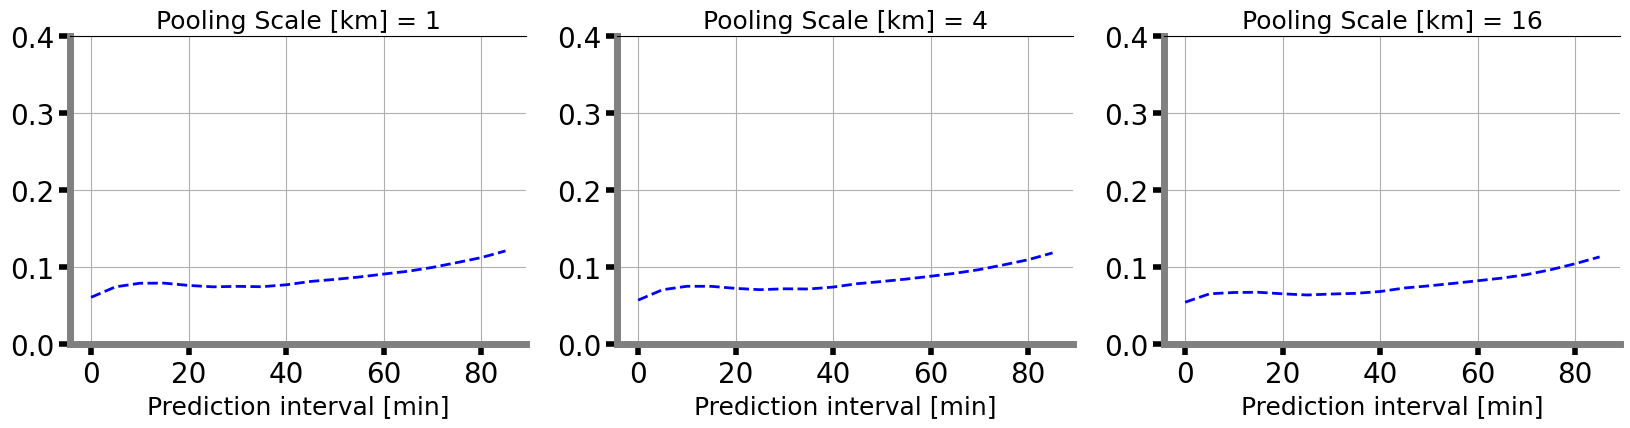

In [11]:
data = next(test_dataset.create_dict_iterator())

images = ops.cast(data["inputs"], ms.float32)

future_images = ops.cast(data["labels"], ms.float32)

pred = inference_module.forecast(g_model, images)

x, y = pred.squeeze(2), future_images.squeeze(2)
fig = plt.figure(figsize=(20, 4))
for index, scale in enumerate([1, 4, 16]):
    ax = fig.add_subplot(1, 3, index+1)
    crps_max_score = inference_module.cal_crps_max(x, y, scale=scale)
    plt_crps_max(crps_max_score, ax, index)


After training, we use the 20th checkpoint for inference. The visualization of predictions and ground truth is shown below.

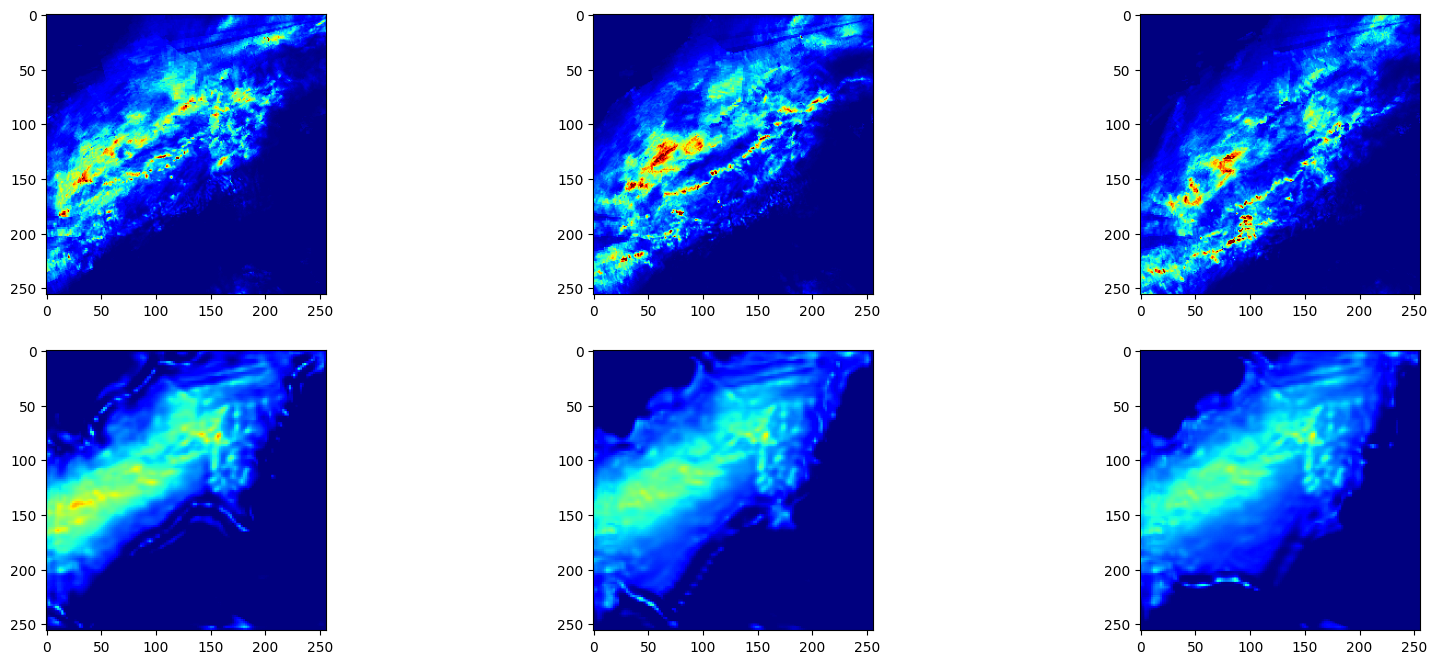

In [13]:
plt_radar_data(x, y)